# Проект: классификация

In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline
plt.style.use('seaborn-v0_8')


## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [357]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
#df.info()
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [358]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [359]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()
# в признаке job имеются пропущенные значения, которые обозначены "unknown"            

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [360]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# не правильно! df['balance'] = df['balance'].str.replace('[^0-9]', '', regex=True).astype('float')
#df['balance'] = df['balance'].str[:-2]
df['balance'] = df['balance'].str.replace(',', '.').str.replace(' ', '').str.replace('$', '')
df['balance'] = pd.to_numeric(df['balance']).astype('float')

round(df['balance'].mean(),3)

1529.129

In [361]:
round(df.mean(axis=0),3)

age           41.232
balance     1529.129
day           15.658
duration     371.994
campaign       2.508
pdays         51.330
previous       0.833
dtype: float64

### Задание 4

In [362]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'].fillna(df['balance'].median(), inplace=True)

In [363]:
# задание 2.3
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [364]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].replace('unknown', 'management')
df['education'] = df['education'].replace('unknown', 'secondary')
print(f"Самая популярная работа: {df['job'].mode()[0]}")
print(f"Самое популярное образование: {df['education'].mode()[0]}")


Самая популярная работа: management
Самое популярное образование: secondary


In [365]:
df_filtered = df[(df['job']=='management') & (df['education']=='secondary')] # фильтруем по популярным работе и образованию
round(df_filtered['balance'].mean(),3)

1598.883

### Задание 6

In [366]:
#определение квантилей методом Тьюки
Q1 = df['balance'].quantile(0.25)
Q3 = df['balance'].quantile(0.75)
IQR = Q3 - Q1

# поиск выбросов
threshold = 1.5
outliers = df[(df['balance'] < Q1 - threshold * IQR) | (df['balance'] > Q3 + threshold * IQR)]

print(f'Нижняя граница: {Q1-1.5*IQR}')
print(f'Верхняя граница: {Q3+1.5*IQR}')

df = df.drop(outliers.index) # удаление выбросов
print(f'Количество признаков после удаления выбросов: {df.shape[0]}')

Нижняя граница: -2241.0
Верхняя граница: 4063.0
Количество признаков после удаления выбросов: 10105


<Axes: ylabel='balance'>

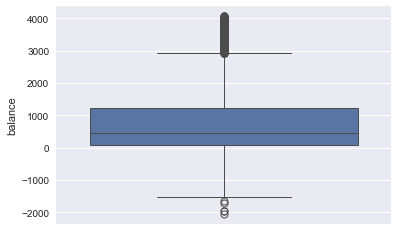

In [367]:
sns.boxplot(df['balance'])

<Axes: ylabel='Frequency'>

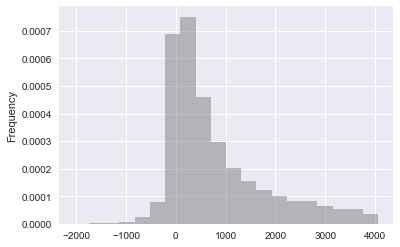

In [368]:
df.balance.plot(kind='hist', density=1, bins=20, stacked=False, alpha=.5, color='grey')

## Часть 2:  Разведывательный анализ

### Задание 1

Распределение по классам:
no     5424
yes    4681
Name: deposit, dtype: int64


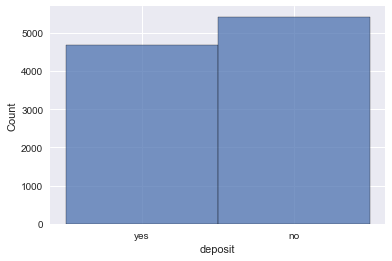

In [369]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
sns.histplot(df['deposit']) # визуализируем классы
print('Распределение по классам:')
print(df['deposit'].value_counts())

### Задания 2 и 3

<Axes: >

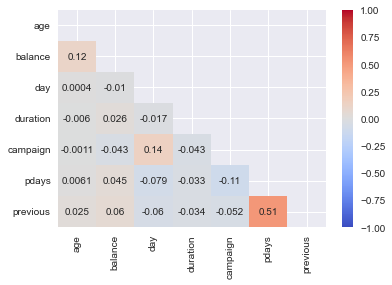

In [370]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
mask = np.triu(df.corr()) # Создаем маску

# Передаем матрицу корреляции. Annot отображает коэффициенты
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=mask)

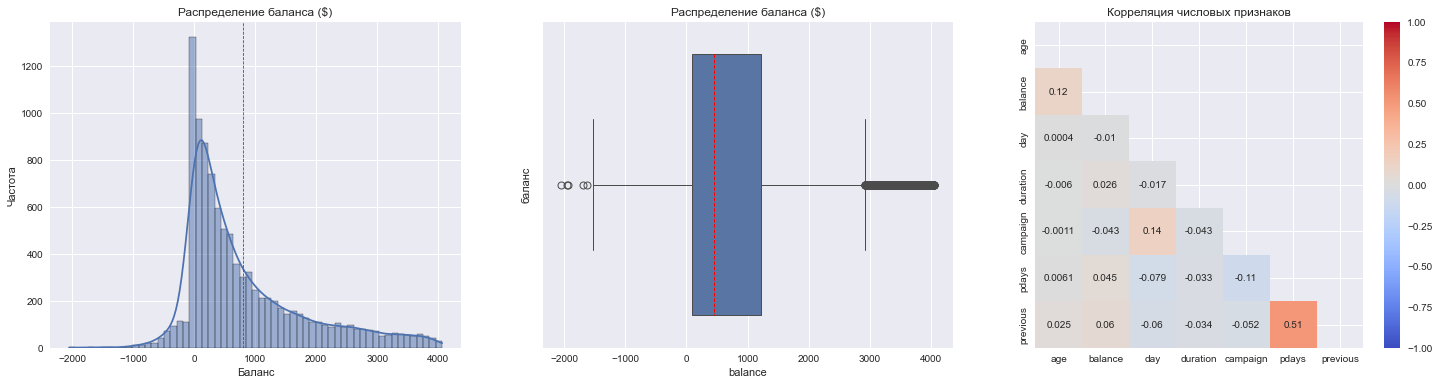

In [371]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))

sns.histplot(df['balance'], kde=True, ax=axes[0])
axes[0].set(xlabel='Баланс', ylabel='Частота')
axes[0].set_title('Распределение баланса ($)')
axes[0].axvline(df['balance'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df['balance'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='баланс')
axes[1].set_title('Распределение баланса ($)')

mask = np.triu(df.corr()) # Создаем маску
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=mask)
axes[2].set_title('Корреляция числовых признаков')

plt.show()

In [372]:
# Каков максимальный возраст клиента банка?
df['age'].describe()

count    10105.000000
mean        40.895497
std         11.734931
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

### Задания 4 и 5

In [374]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [376]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [377]:
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

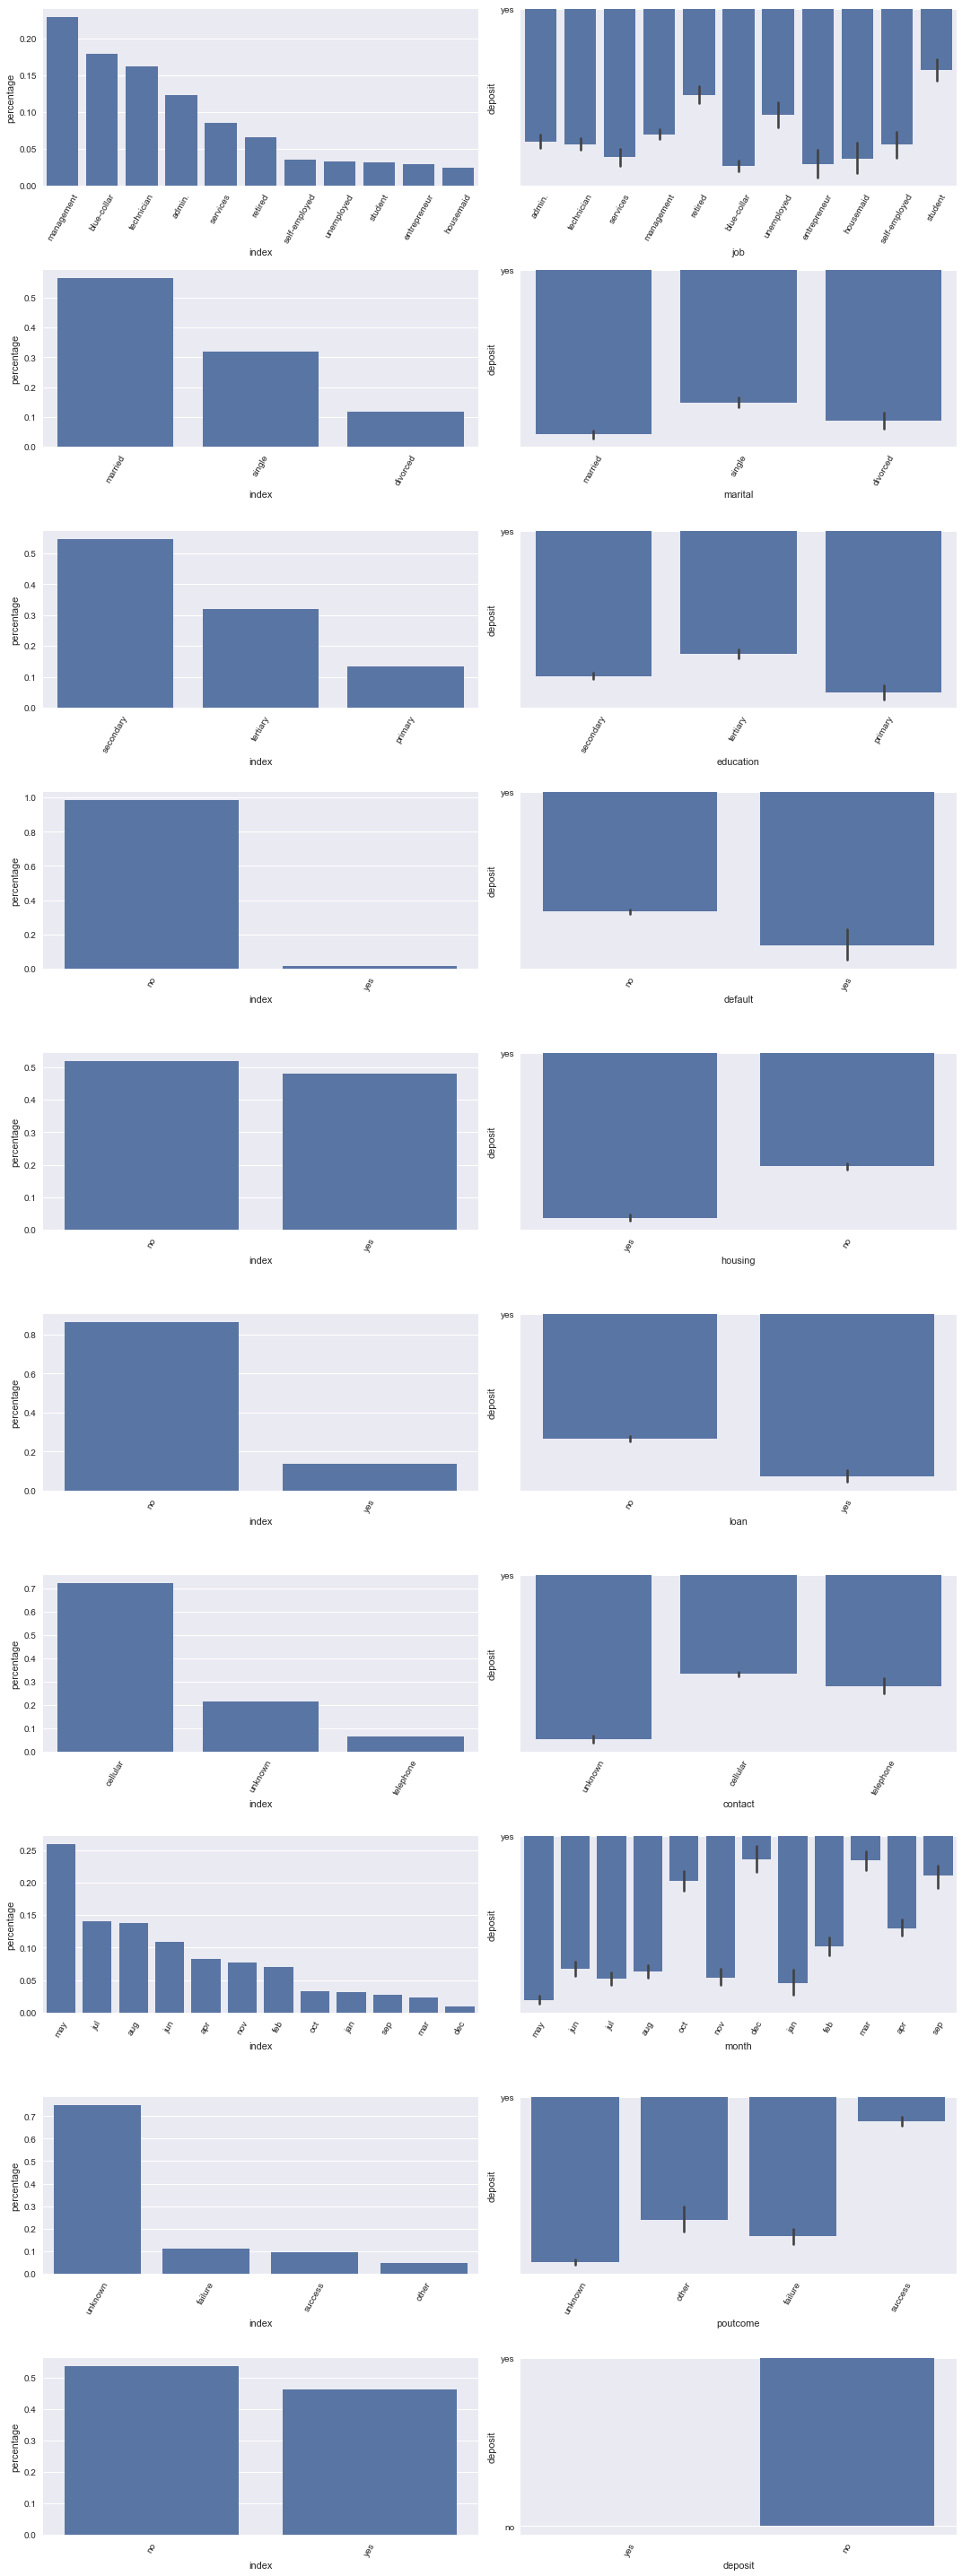

In [380]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

In [385]:
# задание 3.3
# Какова минимальная продолжительность разговора с клиентом банка? Ответ дайте в количестве секунд.
print(f"Минимальная продолжительность разговора: {df['duration'].min()} секунды")

Минимальная продолжительность разговора: 2 секунды


### Задание 6

In [394]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df_filtered_yes = df[(df['deposit']=='yes')]
df_filtered_yes['poutcome'].value_counts()

unknown    3008
success     861
failure     547
other       265
Name: poutcome, dtype: int64

### Задание 7

In [395]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
df_filtered_no = df[(df['deposit']=='no')]
df_filtered_no['month'].value_counts()

may    1776
jul     836
aug     775
jun     606
nov     456
feb     323
apr     317
jan     194
oct      62
sep      46
mar      24
dec       9
Name: month, dtype: int64

### Задание 8

In [ ]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [ ]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [ ]:
# преобразуйте уровни образования

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna